In [31]:
import json
from pathlib import Path

import astropy.uncertainty as unc
import astropy.units as u
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.modeling.models import Linear1D
from astropy.modeling.fitting import LMLSQFitter
from astropy.time import Time

from feadme.parser import Template, Parameter, Line, Shape, Disk, Mask

finfo = np.finfo(float)

In [32]:
disk_profile = Disk(
    name="halpha_disk",
    mask=[Mask(lower_limit=6400, upper_limit=6700)],
    center=Parameter(name="center", distribution="normal", low=6562.819 - 5, high=6562.819 + 5, loc=6562.819, scale=1),
    inner_radius=Parameter(name="inner_radius", distribution="log_uniform", low=1e2, high=5e3),
    delta_radius=Parameter(name="delta_radius", distribution="log_uniform", low=5e2, high=1e4),
    inclination=Parameter(name="inclination", distribution="uniform", low=0, high=np.pi / 2),#, loc=np.pi / 4, scale=np.pi / 8),
    sigma=Parameter(name="sigma", distribution="log_uniform", low=1e2, high=1e4),
    q=Parameter(name="q", distribution="uniform", low=0.5, high=4),
    eccentricity=Parameter(name="eccentricity", distribution="uniform", low=0, high=1),
    apocenter=Parameter(name="apocenter", distribution="uniform", low=0, high=2 * np.pi),#, loc=np.pi, scale=np.pi / 4),
    scale=Parameter(name="scale", distribution="uniform", low=0, high=1),
    offset=Parameter(name="offset", distribution="uniform", low=0, high=0.05, fixed=True, value=0)
)

halpha_narrow_line = Line(
    name="halpha_narrow",
    profile=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6548, high=6568, loc=6562.819, scale=2, shared="halpha_disk"),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=5e3),
)

halpha_broad_line = Line(
    name="halpha_broad",
    profile=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6548, high=6568, loc=6562.819, scale=2, shared="halpha_disk"),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e3, high=2e4),
)

hei_narrow_line = Line(
    name="hei_narrow",
    profile=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6673, high=6683, loc=6678, scale=2),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=5e3),
)

white_noise=Parameter(name="white_noise", distribution="uniform", low=-10, high=1)

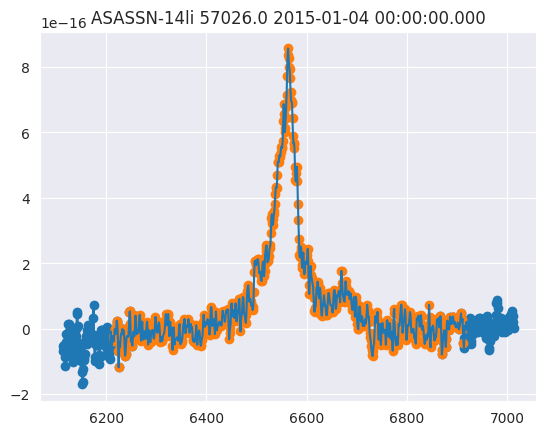

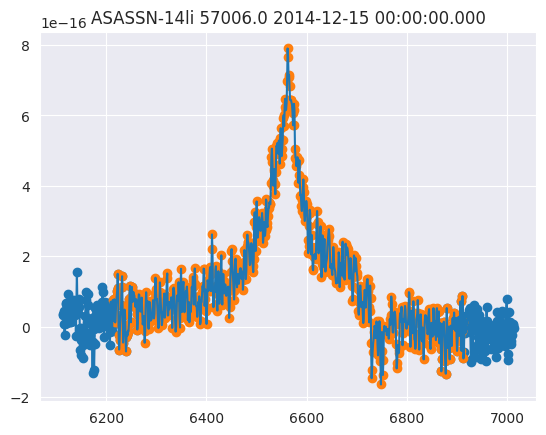

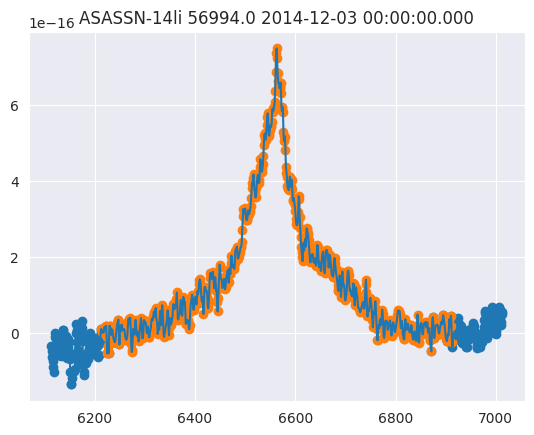

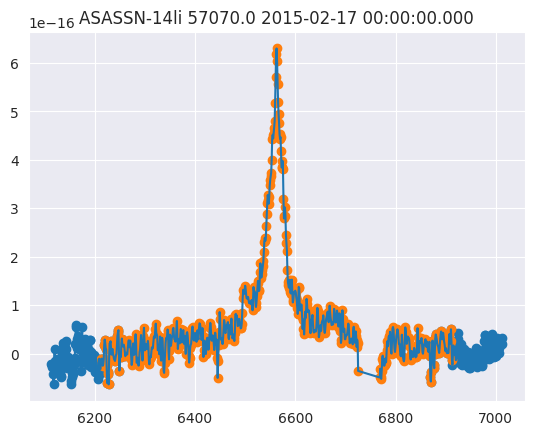

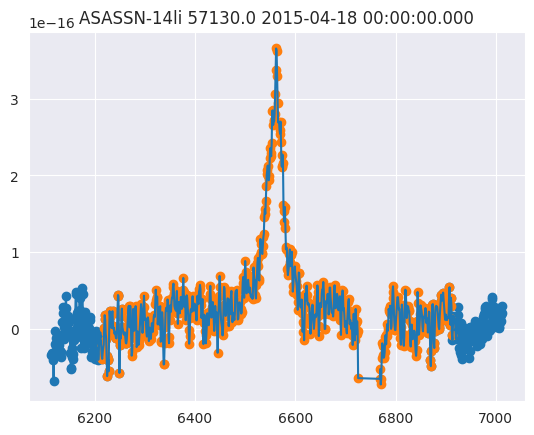

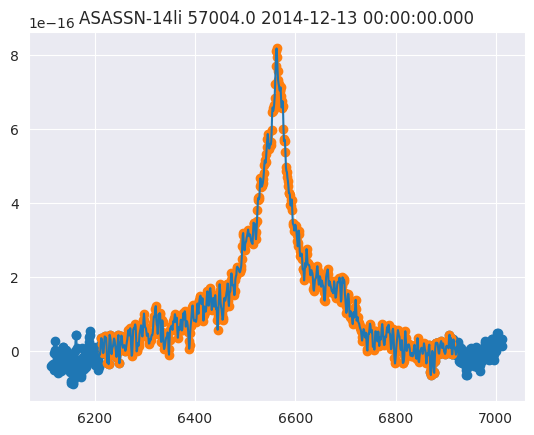

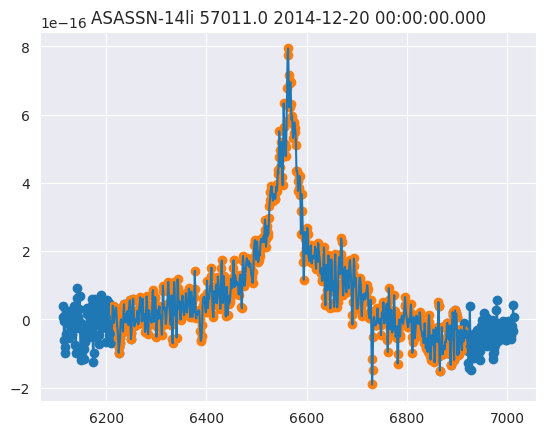

In [33]:
ingest_dir = Path("/home/nmearl/research/tde_agn_comparison/parsed")
output_dir = Path("/home/nmearl/research/tde_agn_comparison")

for file_path in ingest_dir.glob("*.ecsv"):
    for seg in ['14li']:#, '2018hyz', '2018zr',]:#, '2020zso', '09djl']:
        if seg not in file_path.stem:
            continue
    
        tab = Table.read(file_path, format='ascii.ecsv')
        label = tab.meta['name'].replace(',', '').replace(' ', '')
        redshift = tab.meta['redshift']
        mjd = tab.meta['obs_date']
        
        wave = tab['wave'] * u.AA
        flux = tab['flux'] * u.erg / u.s / u.cm ** 2 / u.AA
        flux_err = tab['uncertainty'] * u.erg / u.s / u.cm ** 2 / u.AA
        rest_wave = wave / (1 + redshift)
        ha_mask = (rest_wave.value > 6563 - 350) & (rest_wave.value < 6563 + 350)
        full_mask = (rest_wave.value > 6563 - 450) & (rest_wave.value < 6563 + 450)
        part_mask = (rest_wave.value > 6563 - 300) & (rest_wave.value < 6563 + 300)
        cont_mask = full_mask & ~part_mask
        
        # fit_mod = LMLSQFitter()(Linear1D(), wave[cont_mask], flux[cont_mask])
        # cont_flux = fit_mod(wave)
        # 
        fig, ax = plt.subplots()

        ax.scatter(rest_wave[cont_mask], flux[cont_mask], label='Data')
        ax.plot(rest_wave[full_mask], flux[full_mask], label='Data')
        ax.scatter(rest_wave[ha_mask], flux[ha_mask], label='Data')
        # ax.plot(rest_wave[full_mask], cont_flux[full_mask], label='Continuum')
        # 
        # flux -= cont_flux

        # ax.plot(rest_wave[full_mask], flux[full_mask], label='Continuum Subtracted')
        ax.set_title(f"{label} {mjd} {Time(mjd, format='mjd').iso}")
        
        flux = flux[ha_mask].to(u.mJy, u.spectral_density(wave[ha_mask]))
        flux_err = flux_err[ha_mask].to(u.mJy, u.spectral_density(wave[ha_mask]))
        wave = wave[ha_mask]
    
        Table({'wave': wave, 'flux': flux, 'flux_err': flux_err}).write(
            output_dir / "data" / f"{label}_{mjd}.csv", format='ascii.csv', overwrite=True)
        
        template = Template(
            name=label,
            redshift=redshift,
            data_path=str(output_dir / "data" / f"{label}_{mjd}.csv"),
            disk_profiles=[
                disk_profile,
            ],
            line_profiles=[],
            white_noise=white_noise
        )
        
        if '2018zr' in seg:
            template.line_profiles=[
                halpha_broad_line,
            ]
        elif '2020zso' in seg:
            pass
        elif '2018hyz' in seg:
            template.line_profiles=[
                halpha_broad_line,
            ]
        elif '14li' in seg:
            template.line_profiles=[
                # halpha_narrow_line,
                # halpha_broad_line,
                hei_narrow_line
            ]
        elif '09djl' in seg:
            template.line_profiles=[]
    
        for prof in template.disk_profiles:
            prof.scale.high = flux.max().value * 1.1
    
        for prof in template.line_profiles:
            prof.amplitude.high = flux.max().value * 1.1
    
        with open(output_dir / "tde_templates" / f"{label}_{mjd}.json", "w") as f:
            json.dump(template.model_dump(), f)

In [34]:
Time(59184, format='mjd').iso

'2020-12-01 00:00:00.000'

# Parse Data